In [6]:
from bayes_filter.datapack import DataPack
import tensorflow as tf
import numpy as np
import astropy.time as at
import astropy.coordinates as ac
import astropy.units as au
import gpflow as gp
from bayes_filter.misc import make_coord_array
from bayes_filter.coord_transforms import ITRSToENUWithReferences
from bayes_filter.settings import dist_type, angle_type
from bayes_filter.kernels import DTECIsotropicTimeGeneral
from bayes_filter.plotting import plot_vornoi_map
import pylab as plt

In [2]:
from functools import reduce
import warnings

import tensorflow as tf
import numpy as np
import gpflow as gp

from gpflow import transforms
from gpflow import settings

from gpflow.params import Parameter, Parameterized, ParamList
from gpflow.decors import params_as_tensors, autoflow

float_type = settings.float_type

# class GPRCustom(gp.models.GPR):
#     @gp.params_as_tensors
#     @autoflow((settings.float_type, [None, None]), (settings.float_type, [None, None]))
#     def predict_density_full_cov(self, Xnew, Ynew, ground=False):
#         """
#         Compute the (log) density of the data Ynew at the points Xnew
#         Note that this computes the log density of the data individually,
#         ignoring correlations between them. The result is a matrix the same
#         shape as Ynew containing the log densities.
#         """
#         pred_f_mean, pred_f_var = self._build_predict(Xnew,full_cov=True)
#         #Knn + sigma^2I + Knm (Kmm + sigma^2I)^-1 Kmn
#         if ground:
#             K = pred_f_var
#             L = safe_cholesky(K[0,:,:])
#         else:
#             K = pred_f_var + self.likelihood.variance*tf.eye(tf.shape(Xnew)[0],dtype=Ynew.dtype)
#             L = tf.cholesky(K)[0,:,:]
#         return gp.logdensities.multivariate_normal(Ynew, pred_f_mean, L)
    
#     @gp.params_as_tensors
#     @autoflow((settings.float_type, [None, None]), (settings.float_type, [None, None]))
#     def predict_density_independent(self, Xnew, Ynew, ground=False):
#         """
#         Compute the (log) density of the data Ynew at the points Xnew
#         Note that this computes the log density of the data individually,
#         ignoring correlations between them. The result is a matrix the same
#         shape as Ynew containing the log densities.
#         """
#         pred_f_mean, pred_f_var = self._build_predict(Xnew,full_cov=False)
#         if ground:
#             var = pred_f_var
#         else:
#             #diag(Knn + sigma^2I + Knm (Kmm + sigma^2I)^-1 Kmn)
#             var = pred_f_var + self.likelihood.variance
#         return gp.logdensities.gaussian(Ynew, pred_f_mean, var)[:,0]
    
#     @gp.name_scope('likelihood')
#     @params_as_tensors
#     def _build_likelihood(self):
#         r"""
#         Construct a tensorflow function to compute the likelihood.
#             \log p(Y | theta).
#         """
#         K = self.kern.K(self.X) + tf.eye(tf.shape(self.X)[0], dtype=settings.float_type) * self.likelihood.variance
#         L = safe_cholesky(K)
#         m = self.mean_function(self.X)
#         logpdf = multivariate_normal(self.Y, m, L)  # (R,) log-likelihoods for each independent dimension of Y

#         return tf.reduce_sum(logpdf)
    
class DTECKernel(gp.kernels.Kernel):
    def __init__(self, input_dim, variance=1., lengthscales=10.0,
                 a = 200., b = 100., resolution=10,
                 active_dims=None, fed_kernel='RBF', obs_type='DTEC',name=None):
        """
        - input_dim is the dimension of the input to the kernel
        - variance is the (initial) value for the variance parameter
        - lengthscales is the initial value for the lengthscales parameter
          defaults to 1.0 (ARD=False) or np.ones(input_dim) (ARD=True).
        - active_dims is a list of length input_dim which controls which
          columns of X are used.
        """
        super().__init__(input_dim, active_dims, name=name)
        self.variance = Parameter(variance, transform=transforms.positiveRescale(variance),
                                  dtype=settings.float_type)
        # (3,)
        self.lengthscales = Parameter(lengthscales, transform=transforms.positiveRescale(lengthscales),
                                      dtype=settings.float_type)
#         # (3,)
#         self.velocity = Parameter(velocity, transform=transforms.positive,
#                                       dtype=settings.float_type)
        self.a = Parameter(a, transform=transforms.positiveRescale(a),
                                      dtype=settings.float_type)
        self.b = Parameter(b, transform=transforms.positiveRescale(b),
                                      dtype=settings.float_type)
        self.resolution = resolution
        self.obs_type = obs_type
        self.fed_kernel = fed_kernel

    @params_as_tensors
    def Kdiag(self, X, presliced=False):
        if not presliced:
            X, _ = self._slice(X, None)
        return tf.diag_part(self.K(X,None))

    @params_as_tensors
    def K(self, X, X2=None, presliced=False):
        
        if not presliced:
            X, X2 = self._slice(X, X2)
            
        kern = DTECIsotropicTimeGeneral(variance=self.variance, lengthscales=self.lengthscales,
                                a= self.a, b=self.b, fed_kernel=self.fed_kernel, obs_type=self.obs_type,
                               squeeze=True,#ode_type='adaptive',
                               kernel_params={'resolution':self.resolution})
        return kern.K(X,X2)

(648, 13)
(648, 1)
-2712.4840209141203                            class             prior   transform  trainable  \
GPR/kern/a             Parameter  N(250.0,10000.0)  200.0* +ve       True   
GPR/kern/b             Parameter   N(100.0,2500.0)  100.0* +ve       True   
GPR/kern/lengthscales  Parameter      N(15.0,25.0)   10.0* +ve       True   
GPR/kern/variance      Parameter              None    1.0* +ve       True   

                      shape  fixed_shape  value  
GPR/kern/a               ()         True  220.0  
GPR/kern/b               ()         True  120.0  
GPR/kern/lengthscales    ()         True   10.0  
GPR/kern/variance        ()         True    4.0  
-32590.018281956414 [array(2.89053434), array(16.22474655), array(187.27604593), array(64.21033343)]
-7458.373933870795 [array(5.23568391), array(19.91483092), array(254.90994126), array(197.38838962)]
-4023.609250474662 [array(0.90398235), array(8.53237913), array(312.77157139), array(187.08110242)]
-3426.3854738226873 [ar

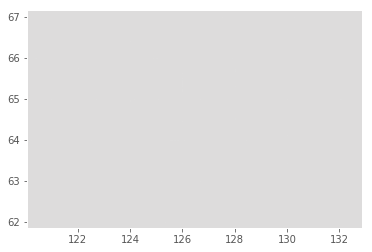

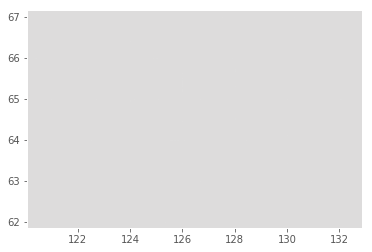

1


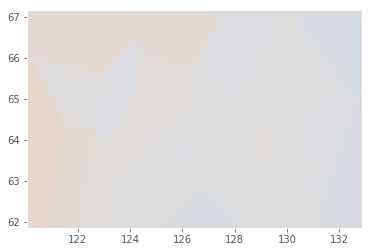

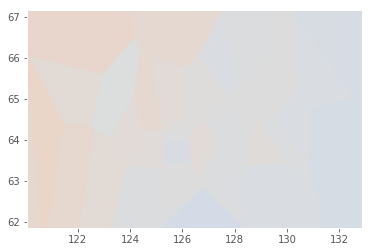

2


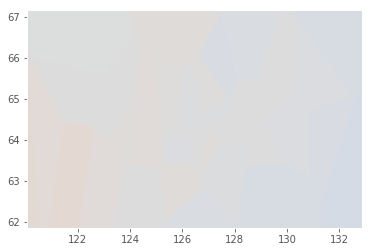

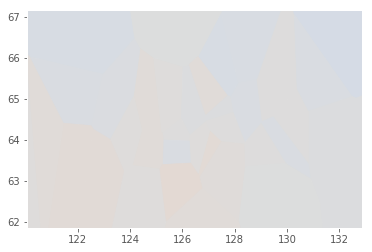

3


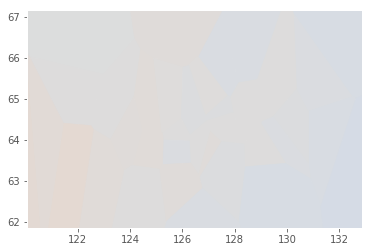

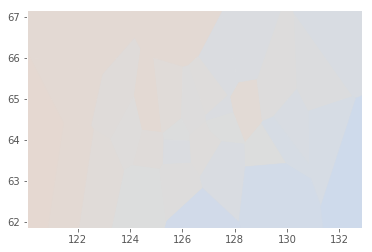

4


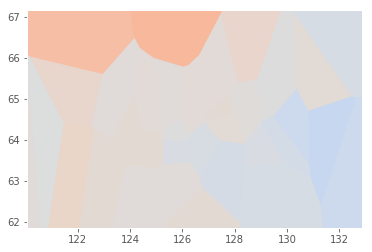

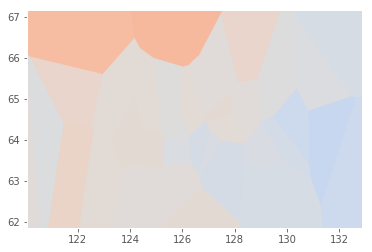

5


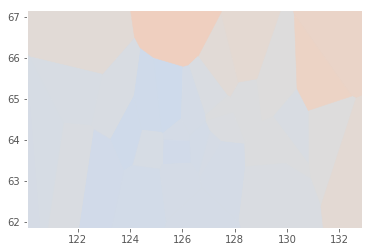

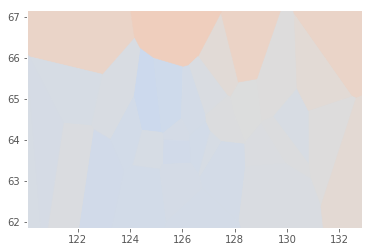

6


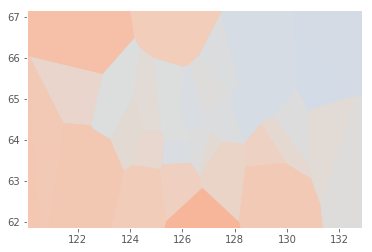

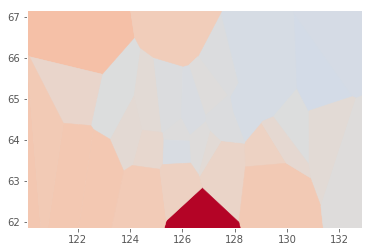

7


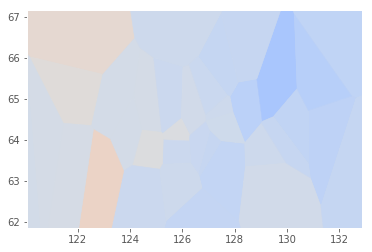

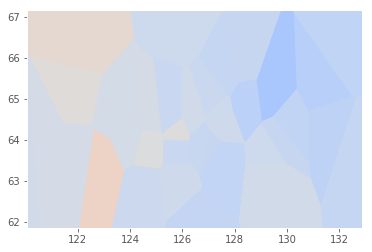

8


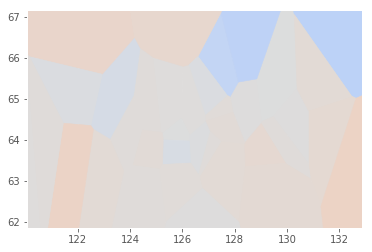

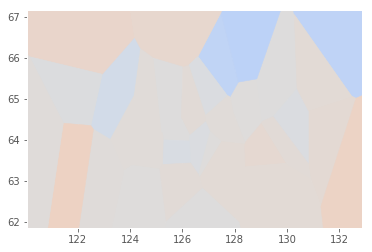

9


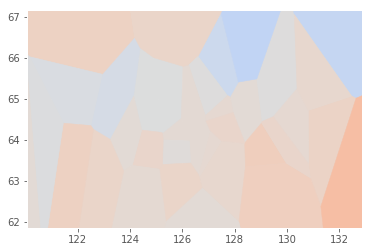

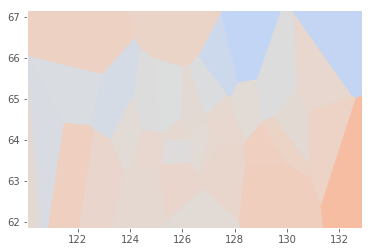

10


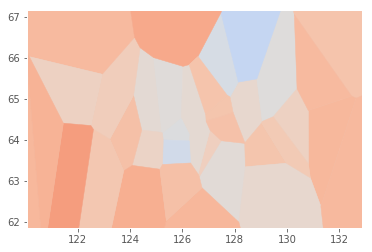

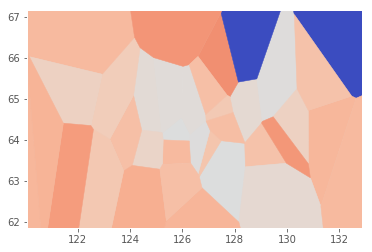

11


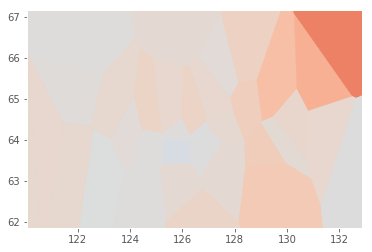

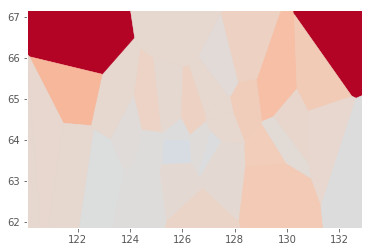

12


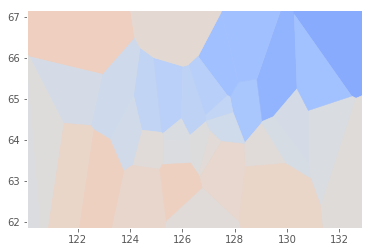

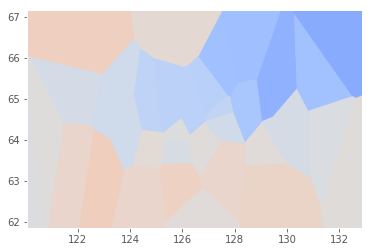

13


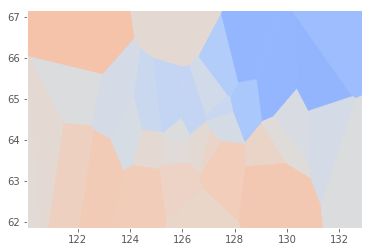

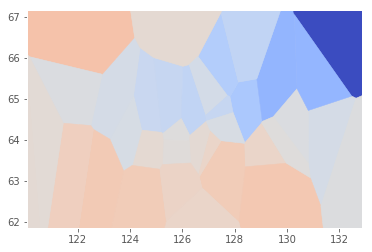

14


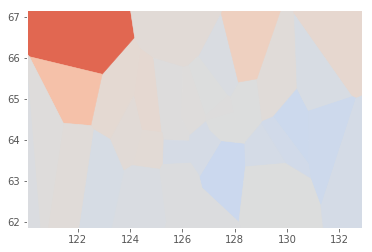

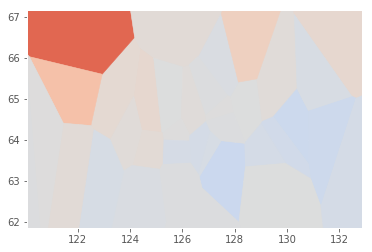

15


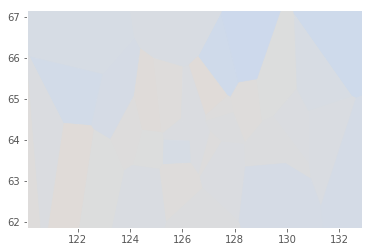

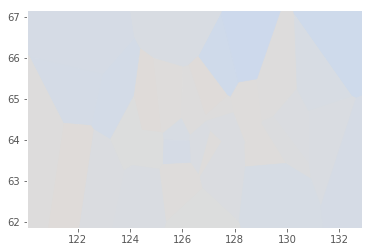

16


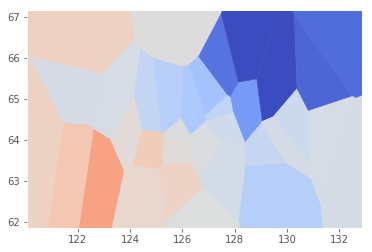

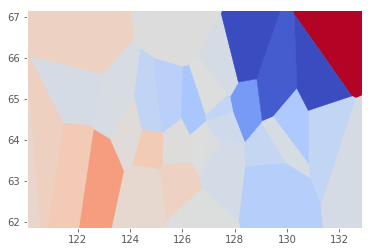

17


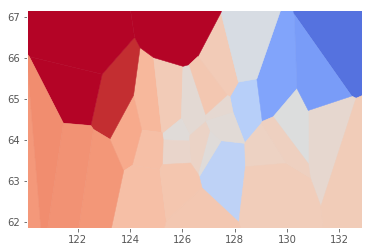

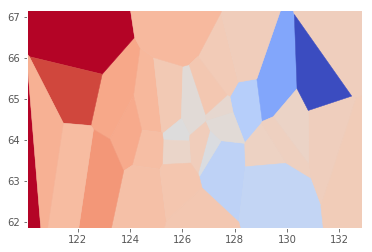

In [34]:
datapack = DataPack('/home/albert/lofar1_1/imaging/data/P126+65_compact_raw/P126+65_full_compact_raw_v7.h5', readonly=True)
select = dict(pol=slice(0,1,1),
             ant=[0] + list(range(45,62,1)),
             dir=slice(None,None,1),
             time=slice(0,1,1))
datapack.current_solset = 'data_posterior'
datapack.select(**select)
tec, axes = datapack.tec
tec_uncert, axes = datapack.weights_tec

#Nd, Na, Nt -> Nt, Nd, Na
tec = tec[0,...].transpose((2,0,1))
tec_uncert = tec_uncert[0,...].transpose((2,0,1))

_, times = datapack.get_times(axes['time'])
Xt = (times.mjd*86400.)[:, None]
_, directions = datapack.get_directions(axes['dir'])
Xd = np.stack([directions.ra.to(angle_type).value, directions.dec.to(angle_type).value],axis=1)
_, antennas = datapack.get_antennas(axes['ant'])
Xa = antennas.cartesian.xyz.to(dist_type).value.T

with tf.Session(graph=tf.Graph()) as sess:
    X = make_coord_array(Xt, Xd, Xa,flat=False)[0,...]
    X = sess.run(ITRSToENUWithReferences(Xa[0,:], Xd[3,:], Xa[0,:])(X))
    X = X.reshape((-1,13))
    print(X.shape)
    with gp.defer_build():
        kern = DTECKernel(13, variance=1., lengthscales=10.0,
                     a = 200., b = 100., resolution=4,
                     fed_kernel='M52', obs_type='DDTEC')
        kern.lengthscales.prior = gp.priors.Gaussian(15.,5.**2)
        kern.a.prior = gp.priors.Gaussian(250.,100.**2)
        kern.b.prior = gp.priors.Gaussian(100.,50.**2)
        
    Y = tec.reshape((-1,1))
    print(Y.shape)
    model = gp.models.GPR(X,Y,kern)
    model.likelihood.variance = 10.**2
    model.likelihood.variance.trainable = False
    
#     best_log_likelihood = -np.inf
#     best_hyperparams = []
#     for i in range(20):
#         kern.variance = np.random.uniform(0.5, 3.5)**2
#         kern.lengthscales = np.random.uniform(8., 25.)
#         kern.a = np.random.uniform(180., 350.)
#         kern.b = np.random.uniform(50., 200.)
#         l = model.compute_log_likelihood()
#         if l > best_log_likelihood:
#             best_hyperparams.append([kern.variance.value,
#                                      kern.lengthscales.value,
#                                      kern.a.value,
#                                      kern.b.value])
#             best_log_likelihood = l
#             print(l, best_hyperparams[-1])
            
    kern.variance = 2.**2#best_hyperparams[-1][0]
    kern.lengthscales = 10.#best_hyperparams[-1][1]
    kern.a = 220.#best_hyperparams[-1][2]
    kern.b = 120.#best_hyperparams[-1][3]
    
#     gp.train.ScipyOptimizer().minimize(model)
    print(model.compute_log_likelihood(), kern)
    ystar, varstar = model.predict_f(X)
#     ystar = ystar.reshape(tec.shape)
    
    mask = np.abs(ystar[:,0] - Y[:,0]) < 10.
    
    X_ = X[mask,:]
    Y_ = Y[mask,:]
    
    model = gp.models.GPR(X_,Y_,kern)
    model.likelihood.variance = 0.1**2
    model.likelihood.variance.trainable = False
    
    best_log_likelihood = -np.inf
    best_hyperparams = []
    for i in range(20):
        kern.variance = np.random.uniform(0.5, 3.5)**2
        kern.lengthscales = np.random.uniform(8., 25.)
        kern.a = np.random.uniform(180., 350.)
        kern.b = np.random.uniform(50., 200.)
        l = model.compute_log_likelihood()
        if l > best_log_likelihood:
            best_hyperparams.append([kern.variance.value,
                                     kern.lengthscales.value,
                                     kern.a.value,
                                     kern.b.value])
            best_log_likelihood = l
            print(l, best_hyperparams[-1])
            
    kern.variance = best_hyperparams[-1][0]
    kern.lengthscales = best_hyperparams[-1][1]
    kern.a = best_hyperparams[-1][2]
    kern.b = best_hyperparams[-1][3]
    gp.train.ScipyOptimizer().minimize(model)
#     kern.variance = 2.**2#best_hyperparams[-1][0]
#     kern.lengthscales = 10.#best_hyperparams[-1][1]
#     kern.a = 220.#best_hyperparams[-1][2]
#     kern.b = 120.#best_hyperparams[-1][3]
    ystar, varstar = model.predict_f(X)
    ystar = ystar.reshape(tec.shape)
    
    
    for i in range(Xa.shape[0]):
        print(i)
        plot_vornoi_map(Xd*180/np.pi, ystar[0,:,i], norm=plt.Normalize(-40., 40.),relim=True,cmap=plt.cm.coolwarm)
        plt.show()
        plot_vornoi_map(Xd*180/np.pi, tec[0,:,i], norm=plt.Normalize(-40., 40.),relim=True,cmap=plt.cm.coolwarm)
        plt.show()
    
#M32
# GPR/kern/a                    True   281.8500333881274  
# GPR/kern/b                    True   544.2494738140343  
# GPR/kern/lengthscales         True  3.7065228537077455  
# GPR/kern/variance             True  0.2290375382264273
#Objective function value: 2277.366876

#M52
# GPR/kern/a                    True   306.4283628533981  
# GPR/kern/b                    True  231.77071778428652  
# GPR/kern/lengthscales         True  5.3741863057288475  
# GPR/kern/variance             True   2.621923215303585    
# Objective function value: 2495.138434

#RBF - learn uncert
# GPR/kern/a                    True  337.28828721870747  
# GPR/kern/b                    True  141.75792986963037  
# GPR/kern/lengthscales         True   3.299923073333427  
# GPR/kern/variance             True   4.681783825568516 
# Objective function value: 2451.799611


0


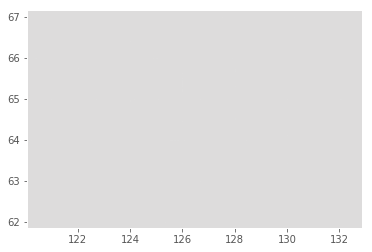

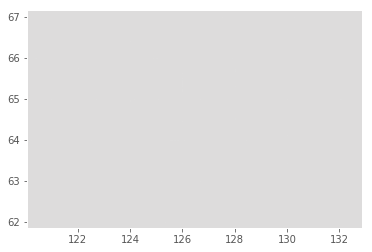

1


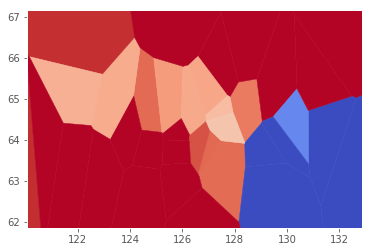

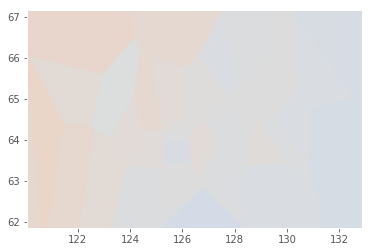

2


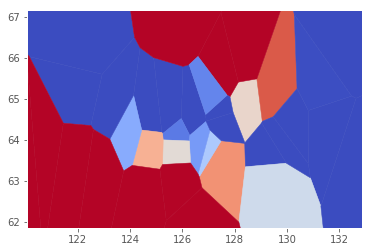

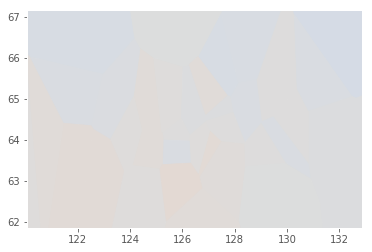

3


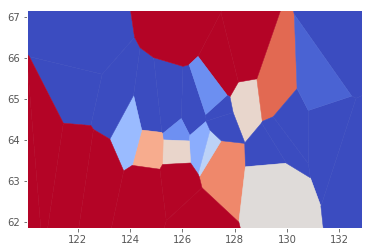

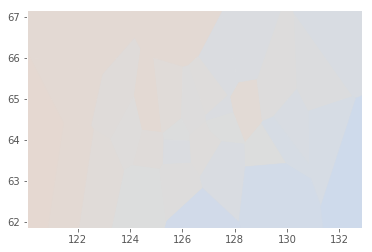

4


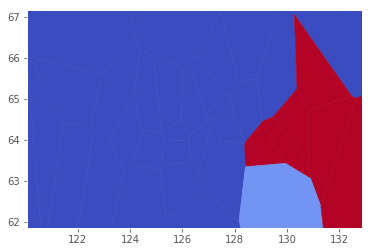

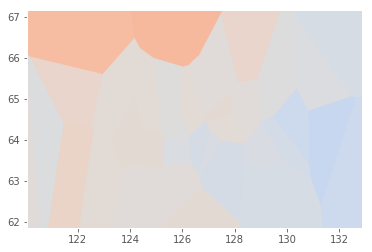

5


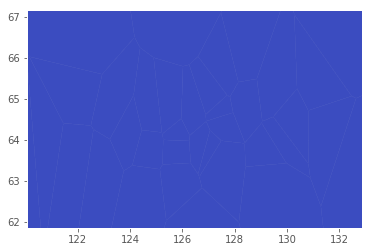

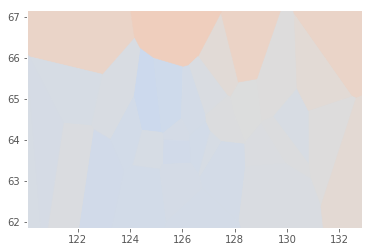

6


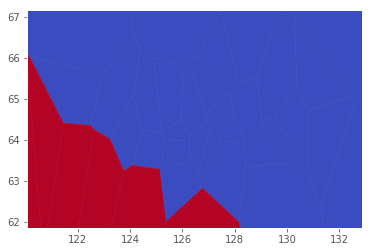

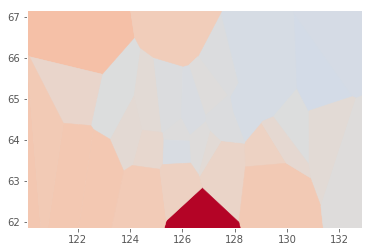

7


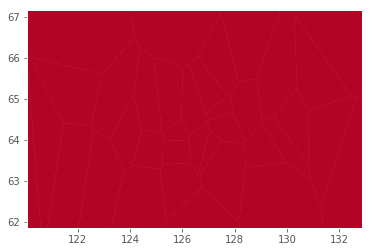

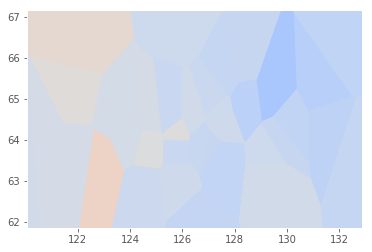

8


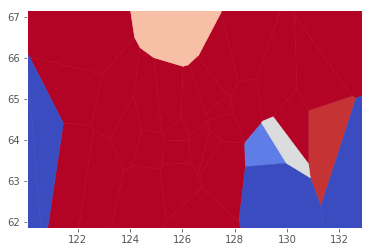

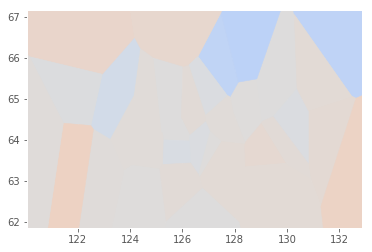

9


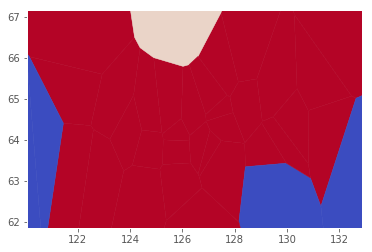

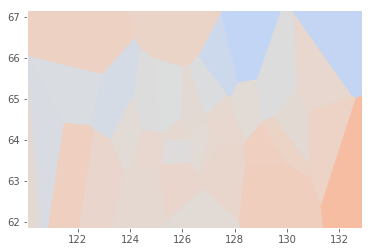

10


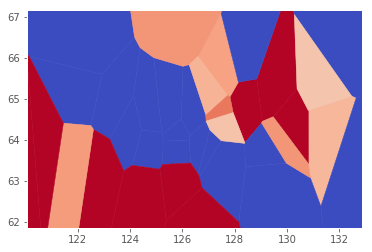

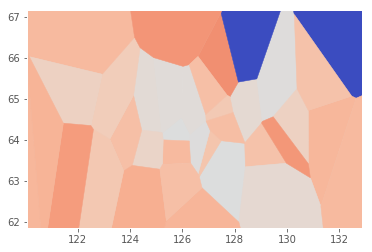

11


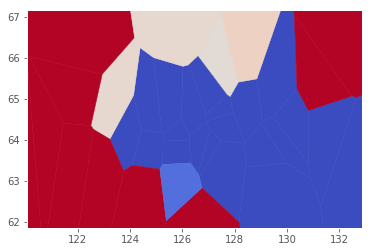

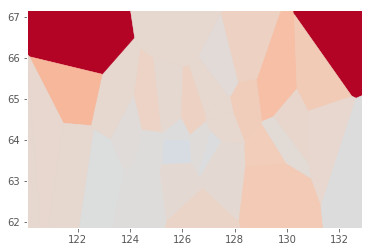

12


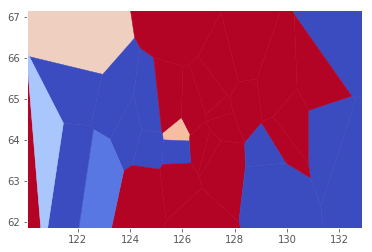

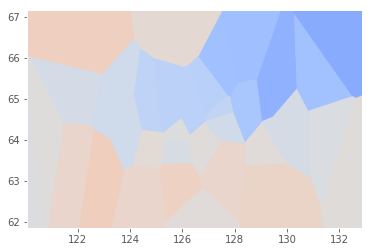

13


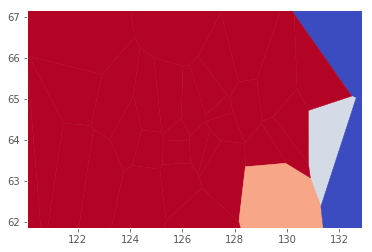

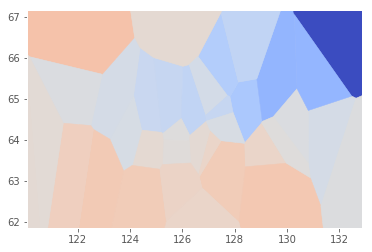

14


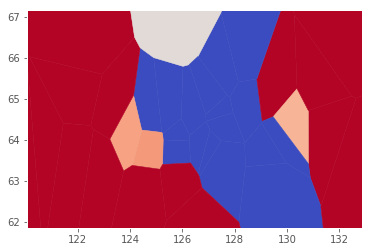

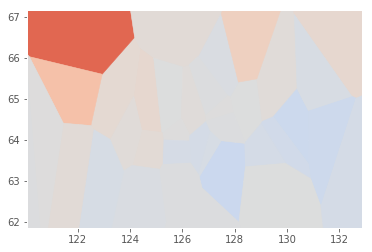

15


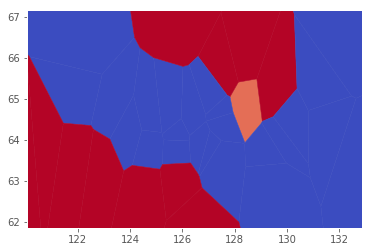

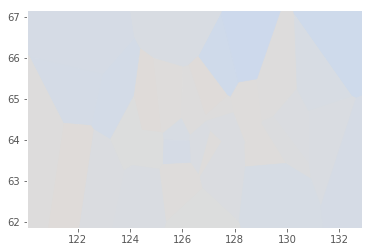

16


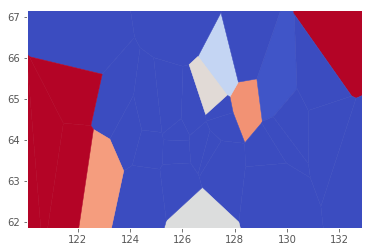

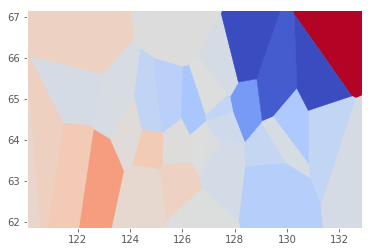

17


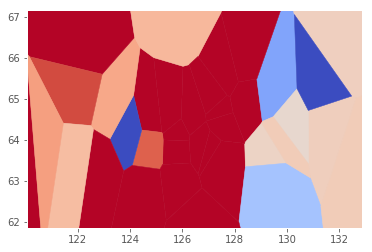

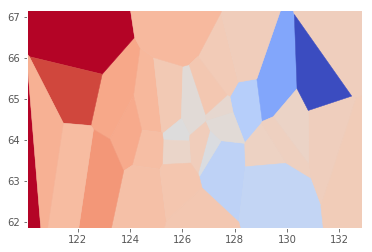

In [28]:
varstar = varstar.reshape(tec.shape)
    
    
for i in range(Xa.shape[0]):
    print(i)
    plot_vornoi_map(Xd*180/np.pi, ystar[0,:,i], norm=plt.Normalize(-40., 40.),relim=True,cmap=plt.cm.coolwarm)
    plt.show()
    plot_vornoi_map(Xd*180/np.pi, tec[0,:,i], norm=plt.Normalize(-40., 40.),relim=True,cmap=plt.cm.coolwarm)
    plt.show()

0


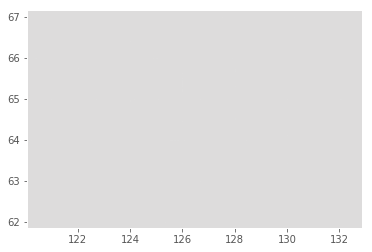

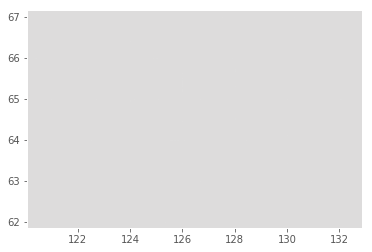

1


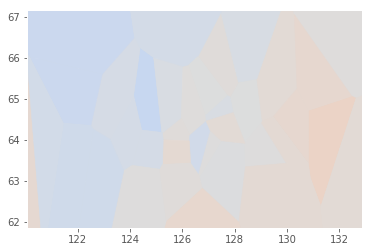

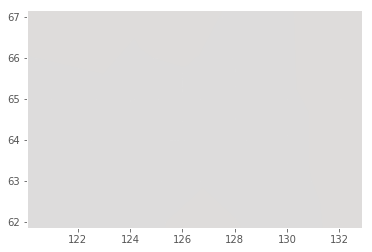

2


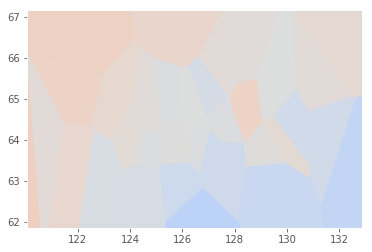

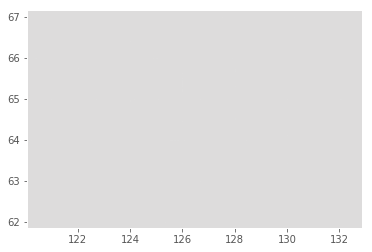

3


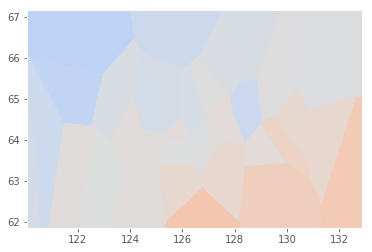

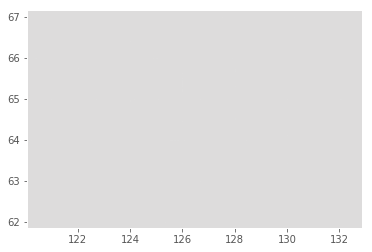

4


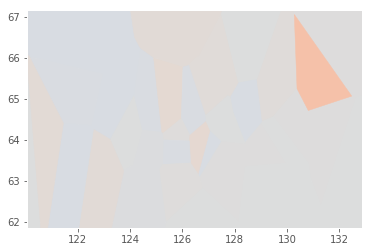

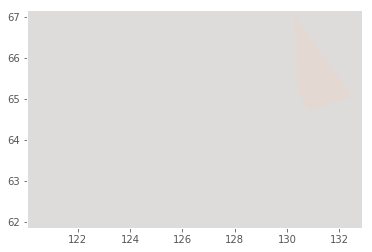

5


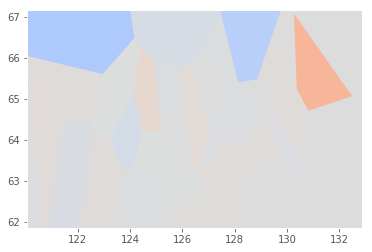

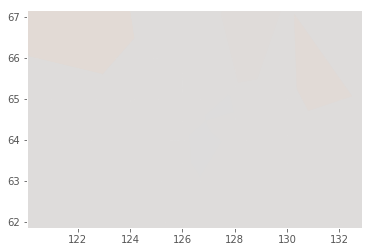

6


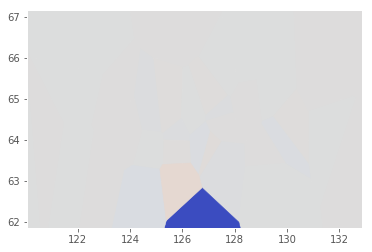

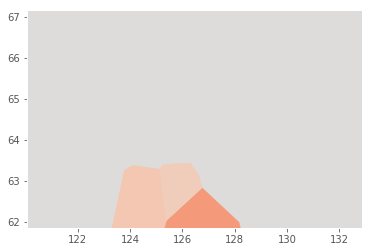

7


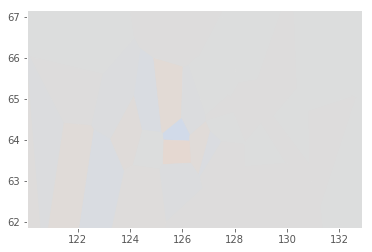

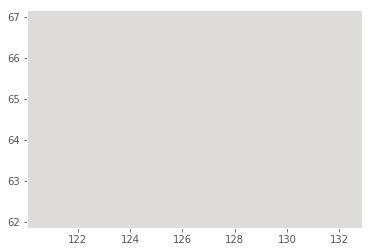

8


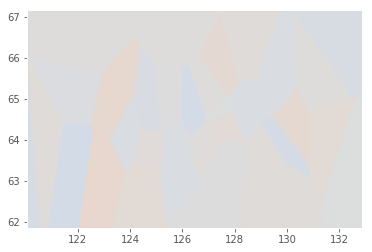

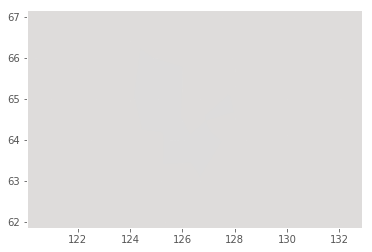

9


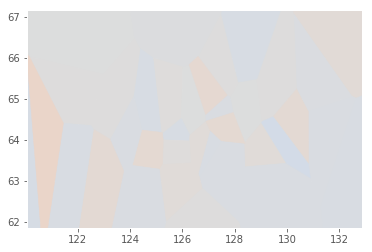

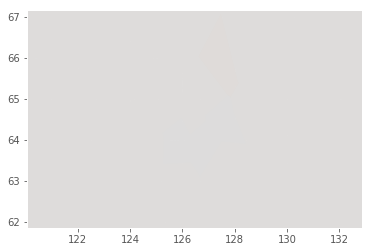

10


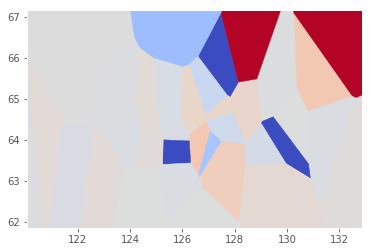

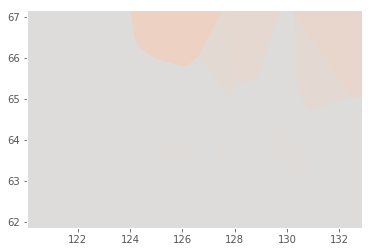

11


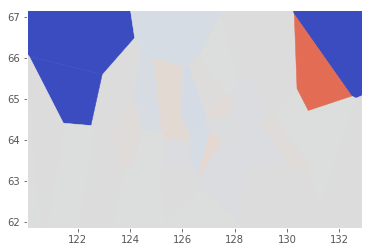

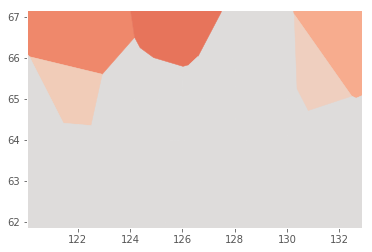

12


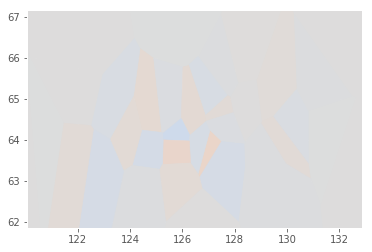

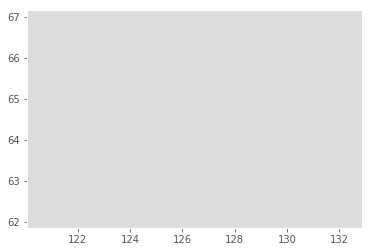

13


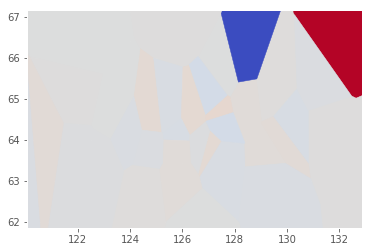

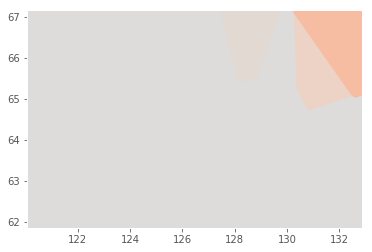

14


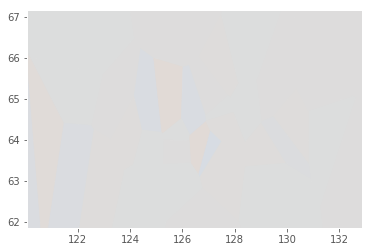

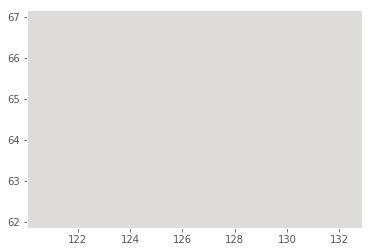

15


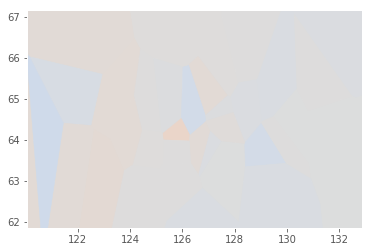

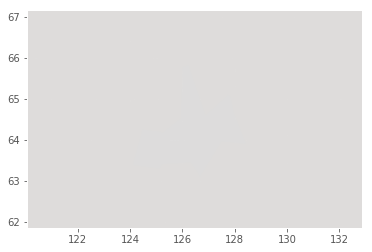

16


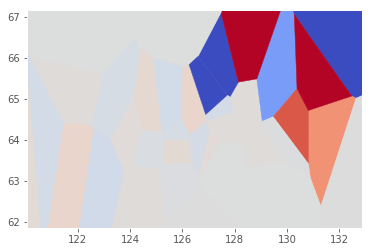

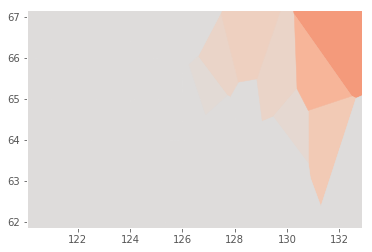

17


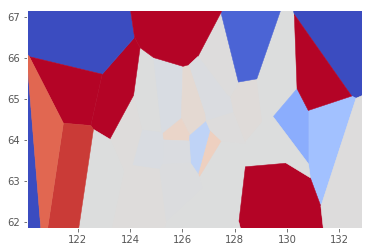

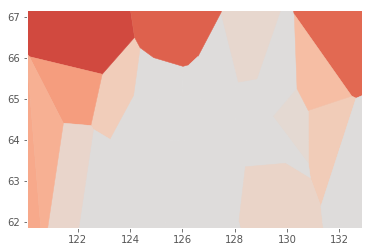

In [36]:
varstar = varstar.reshape(tec.shape)
    
for i in range(Xa.shape[0]):
        print(i)
        plot_vornoi_map(Xd*180/np.pi, ystar[0,:,i] - tec[0,:,i], norm=plt.Normalize(-10., 10.),relim=True,cmap=plt.cm.coolwarm)
        plt.show()
        plot_vornoi_map(Xd*180/np.pi, np.sqrt(varstar[0,:,i]), norm=plt.Normalize(-10., 10.),relim=True,cmap=plt.cm.coolwarm)
        plt.show()
#         plot_vornoi_map(Xd*180/np.pi, tec[0,:,i], norm=plt.Normalize(-40., 40.),relim=True,cmap=plt.cm.coolwarm)
#         plt.show()

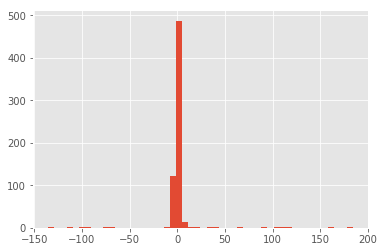

In [33]:
plt.hist((tec-ystar).flatten(),bins=50)
plt.show()

In [37]:
from bayes_filter.misc import get_screen_directions

In [40]:
get_screen_directions('/home/albert/ftp/image.pybdsm.srl.fits')

FileNotFoundError: [Errno 2] No such file or directory: '/home/albert/ftp/image.pybdsm.srl.fits'